In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

## Word Frequency Arrays [TruncatedSVD]

- Each row represents a document, each column represents a particular word
- Entiries measure presence of each word in each document 
- Most entires are 0 though since many words are not included in any document
- Arrays like these are said to be **'sparse'** - most entries are 0.
- This case scipy.sparse.csr_matrix can be used for an alternative to NumPy array
- csr_matrixes saves space since it remembers non-zero entries only
- scikit-learn PCA doesn't support csr_matrixes
- have to use scikit-learn TruncatedSVD instead 
- TruncatedSVD performs same transformations as PCA but accepts **csr_matrixes** as input

In [4]:
documents = ['cats say meow', 'dogs say woof', 'dogs chase cats']

# Create a TfidfVectorizer: tfidf
# Convert a collection of raw documents to a matrix of TF-IDF features.
tfidf = TfidfVectorizer()

# Apply fit_transform to document: csr_mat
csr_mat = tfidf.fit_transform(documents)

print(documents, '\n')

# Print result of toarray() method
print(np.around(csr_mat.toarray(), decimals=2))

# Get the words: words
words = tfidf.get_feature_names()

# Print words
print('\n{}'.format(words))

['cats say meow', 'dogs say woof', 'dogs chase cats'] 

[[0.52 0.   0.   0.68 0.52 0.  ]
 [0.   0.   0.52 0.   0.52 0.68]
 [0.52 0.68 0.52 0.   0.   0.  ]]

['cats', 'chase', 'dogs', 'meow', 'say', 'woof']


## Cluster Wikipedia Articles

* We cluster the articles based on the words frequencies it contains
* We have .csv file with shape of (13000 x 60). Since there would be too many columns for a DF we transpose it and convert it to csr_matrix.

In [10]:
df = pd.read_csv('data/Wikipedia articles/wikipedia-vectors.csv', header=0, index_col=0)
print("df.shape = {}".format(articles.shape))
df.head(2)

df.shape = (13125, 60)


,HTTP 404,Alexa Internet,Internet Explorer,HTTP cookie,Google Search,Tumblr,Hypertext Transfer Protocol,Social search,Firefox,LinkedIn,...,Chad Kroeger,Nate Ruess,The Wanted,Stevie Nicks,Arctic Monkeys,Black Sabbath,Skrillex,Red Hot Chili Peppers,Sepsis,Adam Levine
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.008878,0.0,0.0,0.049502,0.0,0.00000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00611,0.0


In [46]:
# transpose DF and extract articles titles
articles = csr_matrix(df.transpose())
titles = list(df.columns)

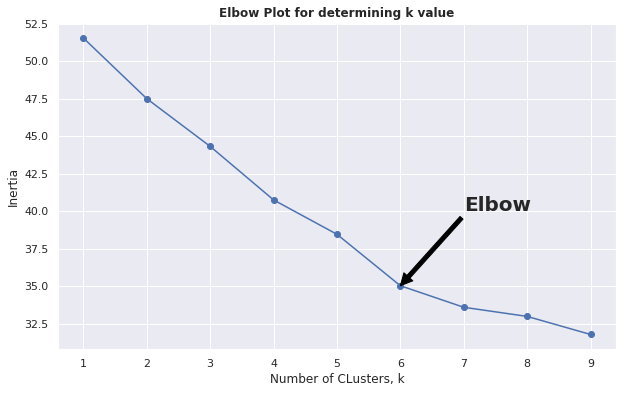

In [47]:
# find the number of cluster from the 'Elbow' plot
k_s = np.arange(1, 10)
svd = TruncatedSVD(n_components=50)
articles_reduced = svd.fit_transform(articles)

inertias=[]
for k in k_s:
    kmeans = KMeans(n_clusters=k).fit(articles_reduced)
    inertias.append(kmeans.inertia_)

def elbow(k_s, inetrias):
    '''Determine the Elbow coordinate'''
    k_s_f = np.array(k_s, dtype=np.float64)
    inertias_f = np.array(inertias, dtype=np.float64)
    derivatives = np.diff(inertias_f)/np.diff(k_s_f)
    k_elbow = np.argmax(np.diff(derivatives)) + 2
    inertia = inertias[k_elbow-1]
    return [k_elbow, inertia]

k, i = elbow(k_s, inertias)

sns.set()
plt.figure(figsize=(10, 6))
plt.plot(k_s, inertias, '-o')
plt.xlabel('Number of CLusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Plot for determining k value', weight='bold')
plt.annotate(s='Elbow', xytext=(7, 40), xy=(k, i),
            arrowprops={'color': 'black'}, weight='bold', fontsize=20)
plt.show()

The optimal number of clusters seems to be **6**. Let's cluster the articles:

In [75]:
svd = TruncatedSVD(n_components=50)
kmeans = KMeans(6)
steps = [('svd', svd), ('kmeans', kmeans)]
pipe = Pipeline(steps)
labels_pred = pipe.fit_predict(articles)

df = pd.DataFrame({'Predicted Labels': labels_pred,
                 'Article Titles': list(titles)})
df.sort_values('Predicted Labels', )

,Predicted Labels,Article Titles
0,0,HTTP 404
1,0,Alexa Internet
2,0,Internet Explorer
3,0,HTTP cookie
4,0,Google Search
5,0,Tumblr
6,0,Hypertext Transfer Protocol
7,0,Social search
8,0,Firefox
9,0,LinkedIn
